In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib

# Trend prediction

## Service functions

In [2]:
def generate_resource_load(max_idx, trend_type):
    lam = 2
    noise = 10*(np.random.poisson(lam, max_idx + 1) - lam)/np.sqrt(lam)
    time_idx = np.sort(np.random.choice(a=list(range(0, max_idx)), size=np.random.randint(max_idx//5, max_idx), replace=False))
    time_idx = np.append(time_idx, max_idx)
    if trend_type == 'linear':
        trend = 10 + time_idx*(70 - 10)/max_idx
    elif trend_type == 'const':
        trend = 30
    elif trend_type == 'exp':
        trend = 3 + np.exp(4*time_idx/max_idx)*(70 - 3)/np.exp(4*max_idx/max_idx)
    else:
        raise Exception(f"Unknown trend type: {trend_type}")
    out_signal = trend + noise[time_idx]
    out_signal = np.clip(out_signal, 0, 100)
    return time_idx, out_signal

In [3]:
def confidence_from_pdf(pdf_y):
    norm = np.linalg.norm(pdf_y)
    if norm > 1e-4:
        pdf_y /= norm
    else:
        return 0
    conf_thr = 1/len(pdf_y) + 0.2  # must be greater than 1/len(pdf_y) to avoid confidence in uniform distribution
    return np.count_nonzero(pdf_y >= conf_thr)/len(pdf_y)


def preprocess_data(res_times, res_vals, stat_window):
    win_pos = 0
    win_end = res_times.max() - stat_window
    out_times = []
    out_means = []
    out_probs = []
    out_pdfs = []
    while win_pos <= win_end:
        idx = np.argwhere((res_times >= win_pos) & (res_times < win_pos + stat_window))
        if len(idx) == 0:
            win_pos += stat_window
            continue
        times = res_times[idx]
        vals = res_vals[idx]

        out_times.append(win_pos + stat_window//2)
        out_means.append(vals.mean())

        PDF_BINS = 20
        PTS_COUNT = len(vals)
        if PTS_COUNT > 0:
            # https://en.wikipedia.org/wiki/Standard_error#Finite_population_correction_(FPC)
            MIN_SAMPLES_PER_BIN = 10  # 10% error?
            DESIRED_SAMPLES = PDF_BINS*MIN_SAMPLES_PER_BIN
            if PTS_COUNT < DESIRED_SAMPLES:
                fpc = np.sqrt((DESIRED_SAMPLES - PTS_COUNT)/(DESIRED_SAMPLES - 1))
            else:
                fpc = 1

            pdf_win_pos = vals.min()
            vals_max = vals.max()
            pdf_win_len = (vals_max + 1e-4 - vals.min())/PDF_BINS
            pdf_high = []
            pdf_low = []
            while pdf_win_pos <= vals_max:
                k = np.count_nonzero((vals >= pdf_win_pos) & (vals < pdf_win_pos + pdf_win_len))
                if k == 0:
                    pdf_high.append(0)  # (1*fpc)
                    pdf_low.append(0)
                    pdf_win_pos += pdf_win_len

                p = k/PTS_COUNT
                moe = 1.96*np.sqrt(p*(1 - p)/PTS_COUNT)*fpc  # https://en.wikipedia.org/wiki/Margin_of_error

                # https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Clopper%E2%80%93Pearson_interval
                binom_stats_high = scipy.stats.binomtest(k=k, n=PTS_COUNT, p=min(p + moe, 1))
                binom_stats_low = scipy.stats.binomtest(k=k, n=PTS_COUNT, p=max(p - moe, 0))
                ci_high = binom_stats_high.proportion_ci(confidence_level=0.95, method='exact')
                ci_low = binom_stats_low.proportion_ci(confidence_level=0.95, method='exact')
                pdf_high.append(max(ci_high.high, ci_low.high)/PDF_BINS)
                pdf_low.append(max(ci_high.low, ci_low.low)/PDF_BINS)

                pdf_win_pos += pdf_win_len
            pdf_high = np.array(pdf_high)
            pdf_low = np.array(pdf_low)
            window_confidence = min(confidence_from_pdf(pdf_high), confidence_from_pdf(pdf_low))  # let's take worst estimation
            out_probs.append(window_confidence)
            out_pdfs.append((np.arange(vals.min(), vals_max + pdf_win_len + 1e-4, pdf_win_len), (pdf_high + pdf_low)/2))
        else:
            out_probs.append(0)
            out_pdfs.append(None)

        win_pos += stat_window

    out_times = np.array(out_times)
    out_means = np.array(out_means)
    out_probs = np.array(out_probs)
    remove_mask = out_probs < 1e-4
    out_times = out_times[~remove_mask]
    out_means = out_means[~remove_mask]
    out_probs = out_probs[~remove_mask]
    remove_idxs = np.argwhere(remove_mask)
    out_pdfs = [elem for i, elem in enumerate(out_pdfs) if i not in remove_idxs]
    return out_times, out_means, out_probs, out_pdfs

In [4]:
def exp_func(x, a, b, c, d):
    return a * np.exp(b * x + d) + c


def predict_warning(times, vals, probs, warn_val):
    ERR_THR = 5  # absolute value
    MAX_PREDICT_HORIZON = 10  # (times.max() - times.min())*MAX_PREDICT_HORIZON

    lin_err = np.inf
    if len(vals) > 1:
        lin_coeffs = np.polyfit(times, vals, 1, w=probs)
        lin_err = np.sqrt((lin_coeffs[1] + times*lin_coeffs[0] - vals)**2).mean()

    exp_err = np.inf
    if len(vals) > 4:
        try:
            popt, _ = scipy.optimize.curve_fit(exp_func, times, vals, p0=(1, 1/times.max(), 0, 0), sigma=1/probs)
            exp_err = np.sqrt((exp_func(times, *popt) - vals)**2).mean()
        except RuntimeError as e:
            print(f"Exponential fit exception: {e}")
            exp_err = np.inf
        if not np.isfinite(exp_err):
            exp_err = np.inf  # just in case, for NaN and -INF

    warn_time = None
    warn_type = None
    forecast_times = None
    forecast_vals = None

    check_lin = lin_err < ERR_THR and abs(lin_coeffs[0]) > 1e-4 and lin_coeffs[0] > 0
    check_exp = exp_err < ERR_THR and abs(popt[0]) > 1e-4 and abs(popt[1]) > 1e-4 and popt[0]*popt[1] > 0
    if check_lin and check_exp:
        if lin_err <= exp_err:
            check_exp = False
        else:
            check_lin = False
    if check_lin:
        warn_time = (warn_val - lin_coeffs[1])/lin_coeffs[0]
        if warn_time < times.max() or warn_time > times.min() + MAX_PREDICT_HORIZON*(times.max() - times.min()):
            warn_time = None
        else:
            forecast_times = np.linspace(times.max(), warn_time, 10)
            forecast_vals = lin_coeffs[1] + lin_coeffs[0]*forecast_times
            warn_type = 'linear'
    if check_exp:
        warn_time = (np.log((warn_val - popt[2])/popt[0]) - popt[3])/popt[1]
        if warn_time < times.max() or warn_time > times.min() + MAX_PREDICT_HORIZON*(times.max() - times.min()):
            warn_time = None
        else:
            forecast_times = np.linspace(times.max(), warn_time, 10)
            forecast_vals = popt[2] + popt[0]*np.exp(popt[1]*forecast_times + popt[3])
            warn_type = 'exponential'
    
    return warn_time, warn_type, forecast_times, forecast_vals

In [5]:
def plot_case(res_times, res_vals, high_warn_level):
    default_figsize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = (15, 7)

    fig, axs = plt.subplots(2, 1, sharex=True, height_ratios=(5, 2))
    axs[0].plot(res_times, res_vals, '.-', c='gray', alpha=0.5)

    time_avg_step = (res_times.max() - res_times.min())/len(res_times)
    time_window_length = min(max((res_times.max() - res_times.min())/10, time_avg_step*50), time_avg_step*100)
    prep_times, prep_means, prep_probs, prep_pdfs = preprocess_data(res_times, res_vals, time_window_length)
    axs[0].plot(prep_times, prep_means, '--', c='blue')

    probs_norm = np.linalg.norm(prep_probs)
    if probs_norm > 1e-4:
        normed_prep_probs = prep_probs/probs_norm
    else:
        normed_prep_probs = np.zeros(len(prep_probs))
    dot_sizes = (100 - 5)*normed_prep_probs + 10
    axs[0].scatter(prep_times, prep_means, s=dot_sizes, c='blue', zorder=100)

    print(f"Estimated probabilities for windows: {prep_probs}")
    warn_time, warn_type, fore_times, fore_vals = predict_warning(prep_times[-10:], prep_means[-10:], prep_probs[-10:], high_warn_level)

    if warn_time is not None:
        axs[0].axhline(high_warn_level, linestyle='--', c='red')
        axs[0].annotate(f"warning = {int(high_warn_level)}%", (res_times.min(), high_warn_level + 1))
        axs[0].plot(fore_times, fore_vals, linestyle='--', c='orange')
        fig.suptitle(f"Prediction: warning level at {warn_time:.2f}, growth: {warn_type}")
    else:
        fig.suptitle("Prediction: no growth to warning level")

    pdf_colormap = matplotlib.colormaps.get_cmap('Greys')
    axs[1].set_ylim(res_vals.min(), res_vals.max())
    for (pdf_xs, pdf_ys), pdf_time in zip(prep_pdfs, prep_times):
        for i in range(len(pdf_ys)):
            rect = matplotlib.patches.Rectangle(
                (pdf_time - time_window_length/2, pdf_xs[i]),
                time_window_length, pdf_xs[i + 1] - pdf_xs[i],
                linewidth=0,
                edgecolor='none',
                facecolor=pdf_colormap(int(256*pdf_ys[i]/pdf_ys.max())),
            )
            axs[1].add_patch(rect)

    plt.show()

    plt.rcParams['figure.figsize'] = default_figsize

## Plots on generated data

In [6]:
GENERATED_DATA_PTS = 700

WARNING_VALUE = 90

Estimated probabilities for windows: [0.2  0.25 0.3  0.4  0.25 0.35 0.25 0.25 0.2  0.2 ]


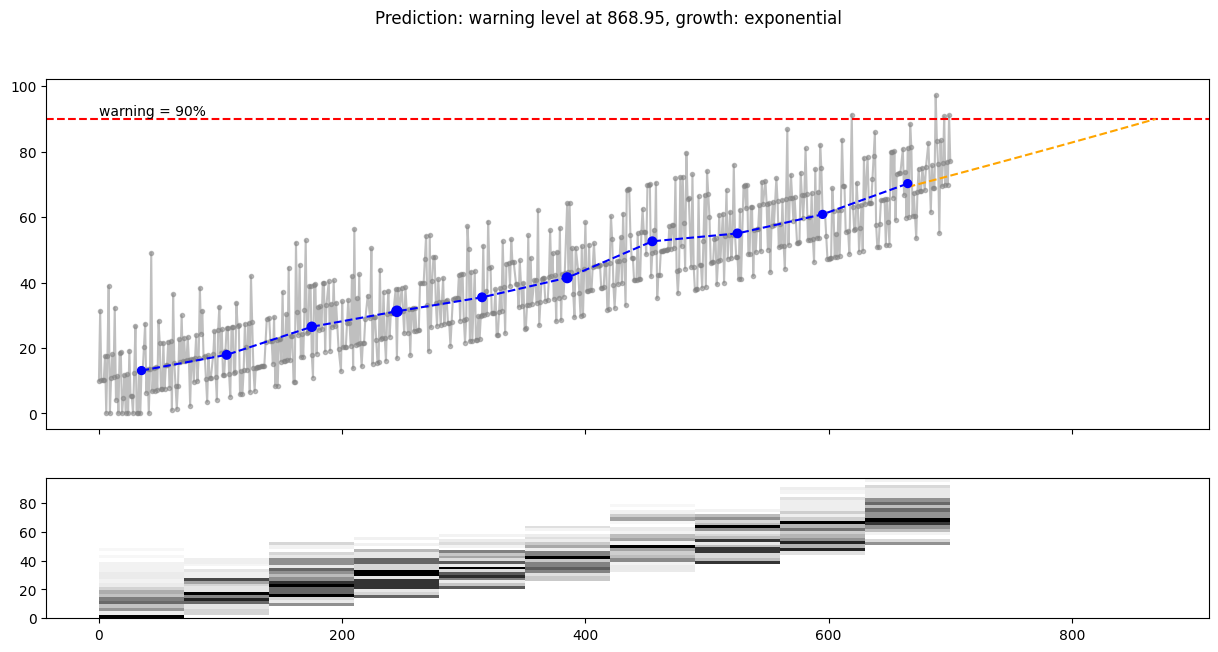

Estimated probabilities for windows: [0.1  0.1  0.15 0.2  0.15 0.1  0.1  0.15 0.1  0.15]
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


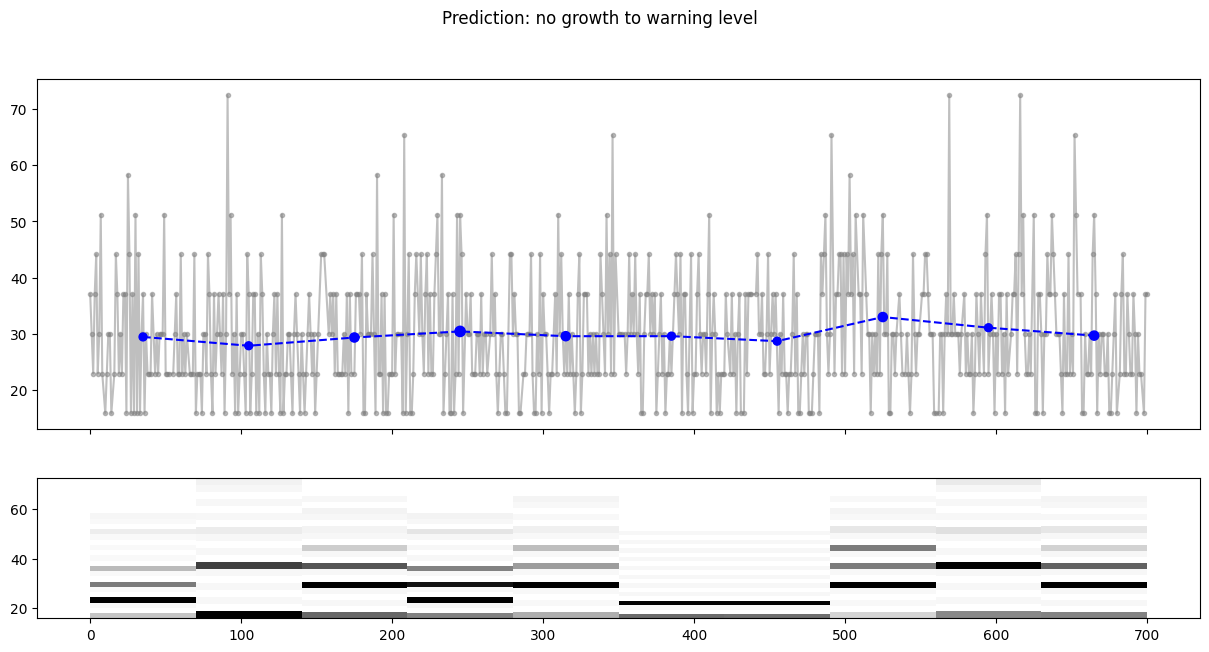

Estimated probabilities for windows: [0.1  0.05 0.05 0.25 0.15 0.25]


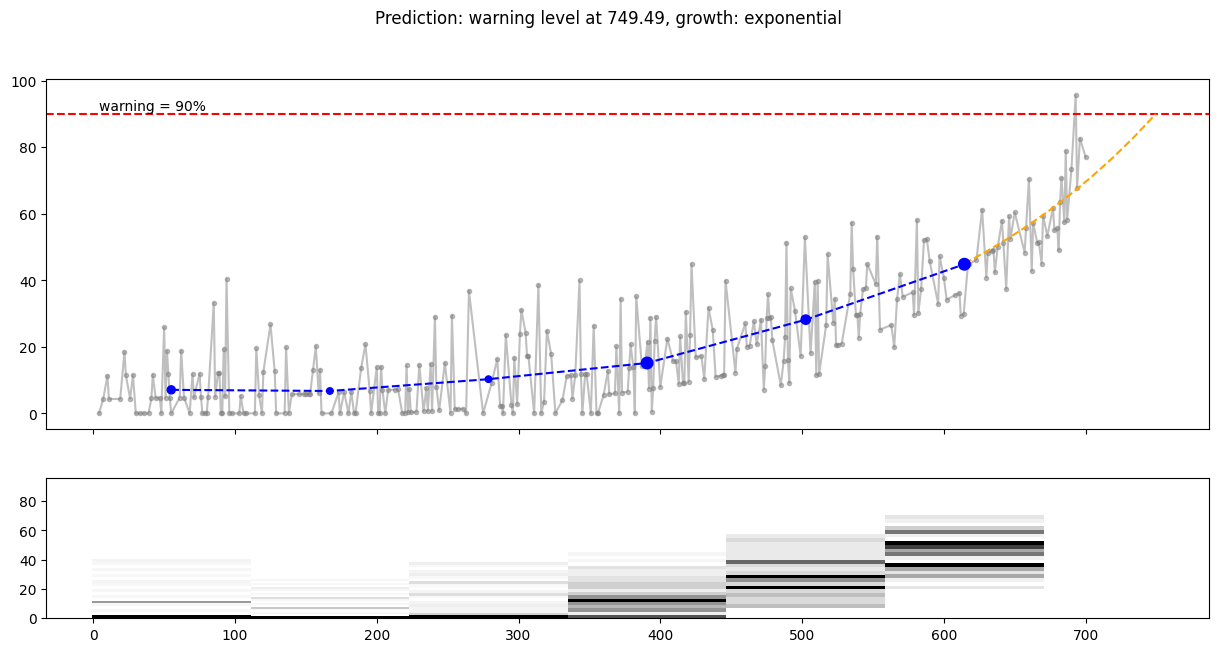

In [7]:
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'linear')
plot_case(res_times, res_vals, WARNING_VALUE)
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'const')
plot_case(res_times, res_vals, WARNING_VALUE)
res_times, res_vals = generate_resource_load(GENERATED_DATA_PTS, 'exp')
plot_case(res_times, res_vals, WARNING_VALUE)

## Plots on real data

Data is taken from [this dataset](https://data.mendeley.com/datasets/rc6rwf7c8n/1).

In [8]:
res_df = pd.read_csv('data/resource_load_dataset/4802498578')

In [9]:
res_times = (res_df.iloc[:, 0] - res_df.iat[0, 0]).to_numpy()/1e7
assert len(np.unique(res_times)) == len(res_times)
res_vals = np.clip(res_df.iloc[:, 2].to_numpy()*100, 0, 100)
assert len(res_vals) == len(res_times)

remove_mask = ~(np.isfinite(res_times) & np.isfinite(res_vals))
res_times = res_times[~remove_mask]
res_vals = res_vals[~remove_mask]

print(f"Data length: {len(res_times)}")

Data length: 31089


Estimated probabilities for windows: [0.1  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.1  0.1  0.2  0.1  0.1  0.15 0.05 0.05 0.05 0.1  0.05 0.05 0.05 0.1
 0.1  0.2  0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.05 0.05 0.05 0.05 0.1
 0.1  0.05 0.05 0.05 0.05 0.05 0.15 0.15 0.15 0.1  0.1  0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.1  0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.1  0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.1
 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.1
 0.05 0.05 0.1  0.05 0.05 0.1  0.05 0.05 0.0

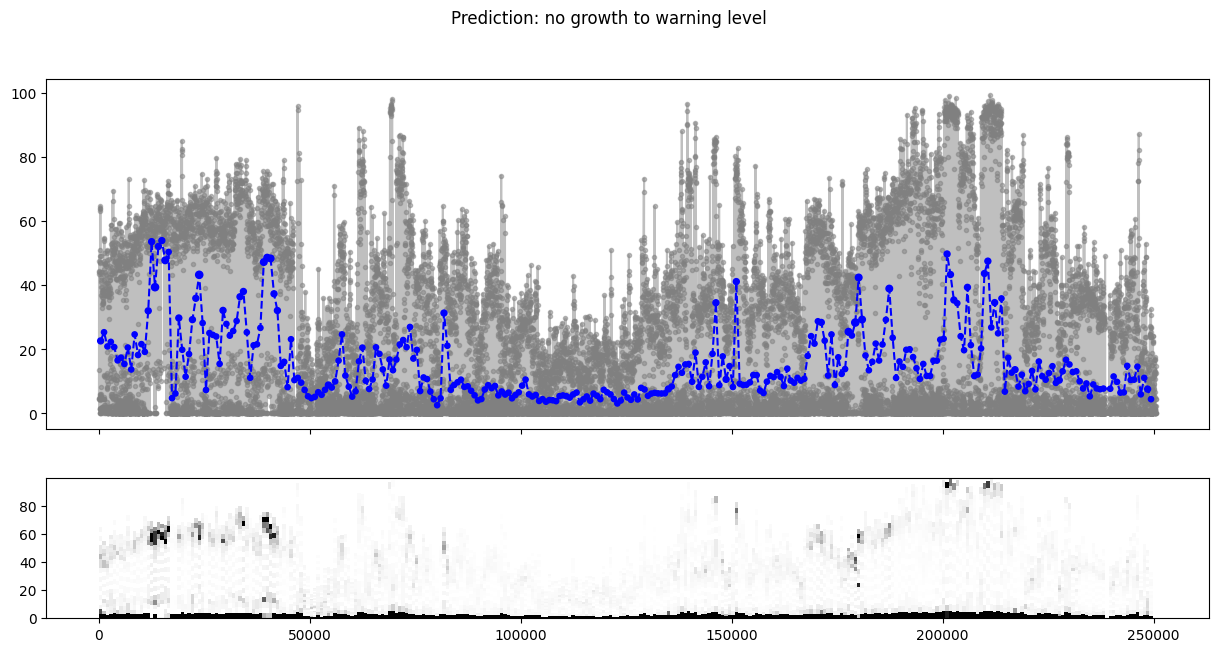

In [10]:
plot_case(res_times, res_vals, WARNING_VALUE)

Estimated probabilities for windows: [0.05 0.05 0.05 0.05 0.05 0.1  0.25 0.15 0.1  0.1 ]
Exponential fit exception: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.


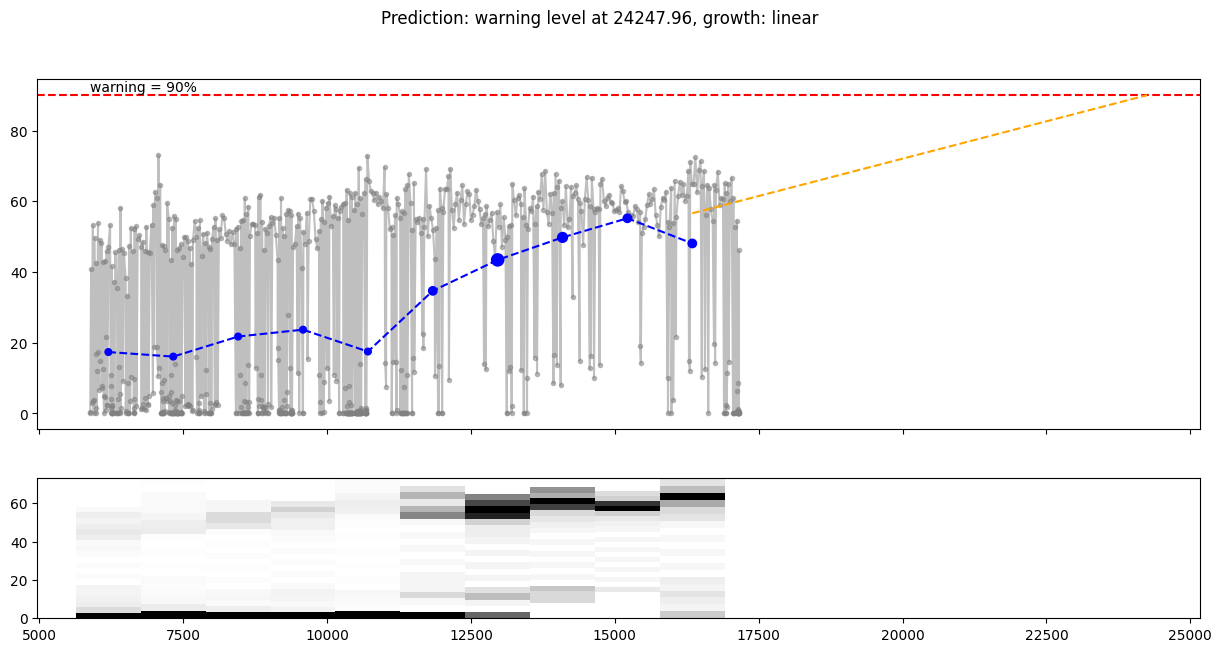

In [11]:
plot_case(res_times[500:1350], res_vals[500:1350], WARNING_VALUE)